# Modelo

### Librerías y carga del dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

### Datos sin procesar

In [2]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0               0                       31      0        596         139   
1               1                       65      0       9339         339   
2               2                      421      0       6483         348   
3               3                      546      0       9557         324   
4               4                      551      0       8848         495   

   MONTO_TX         TX_DATETIME    year  month   day  hour  minute  \
0  57162.95 2023-01-25 00:00:31  2023.0    1.0  25.0   0.0     0.0   
1  28919.23 2023-01-25 00:01:05  2023.0    1.0  25.0   0.0     1.0   
2  50427.64 2023-01-25 00:07:01  2023.0    1.0  25.0   0.0     7.0   
3  21264.14 2023-01-25 00:09:06  2023.0    1.0  25.0   0.0     9.0   
4  27735.93 2023-01-25 00:09:11  2023.0    1.0  25.0   0.0     9.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       17.167312       39.881940         0              

### Datos filtrados

In [3]:
data = data.drop('TRANSACTION_ID', axis=1)
data = data.drop('CLIENTE_ID', axis=1)
data = data[data['TX_FRAUD'] == 1]
data = data.sort_values(by=['TX_DATETIME'])
print(data.head())
print("total-filas: ",len(data) )

   TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX         TX_DATETIME  \
13                     1524      0         466  139447.11 2023-01-25 00:25:24   
18                     1805      0         406   92739.05 2023-01-25 00:30:05   
20                     1911      0         363  115776.96 2023-01-25 00:31:51   
33                     2544      0         483  139610.64 2023-01-25 00:42:24   
34                     2552      0         115  132291.02 2023-01-25 00:42:32   

      year  month   day  hour  minute  x_pos_terminal  y_pos_terminal  \
13  2023.0    1.0  25.0   0.0    25.0        1.287674       14.557697   
18  2023.0    1.0  25.0   0.0    30.0       46.924095       17.151405   
20  2023.0    1.0  25.0   0.0    31.0       42.144992        3.390347   
33  2023.0    1.0  25.0   0.0    42.0       23.700314       17.458371   
34  2023.0    1.0  25.0   0.0    42.0       22.994013       27.317341   

    TX_FRAUD  TX_FRAUD_SCENARIO  
13         1                  1  
18    

### Random Forest

Mean Squared Error (MSE): 0.9318994763054013
Mean Absolute Error (MAE): 0.7332954496897629
R-squared: 0.8782713089406617


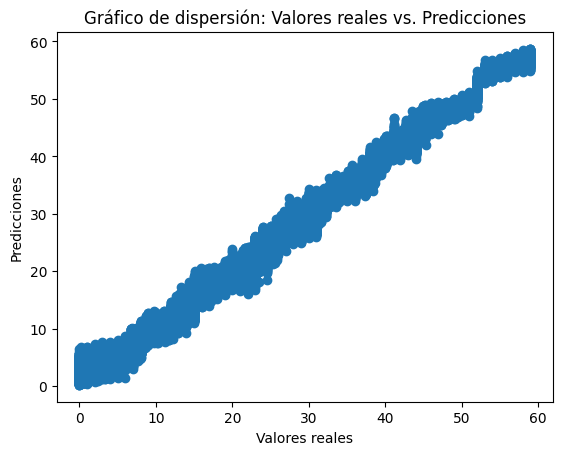

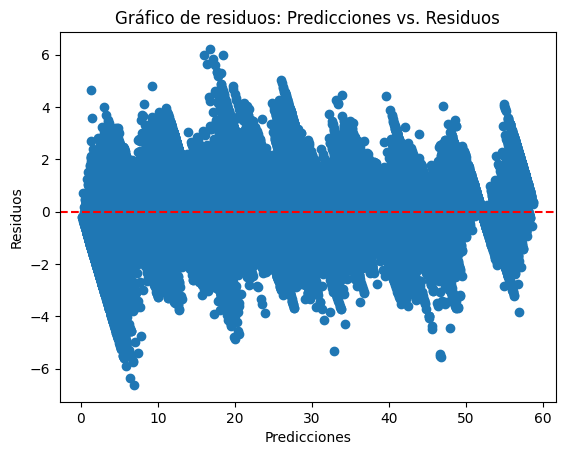

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(oob_score=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs. Predicciones')
plt.show()

# Calcular los residuos
residuals = y_test - y_pred

# Gráfico de residuos
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos: Predicciones vs. Residuos')
plt.axhline(y=0, color='r', linestyle='--')  # Línea de referencia en 0
plt.show()

#### Importancia de variables

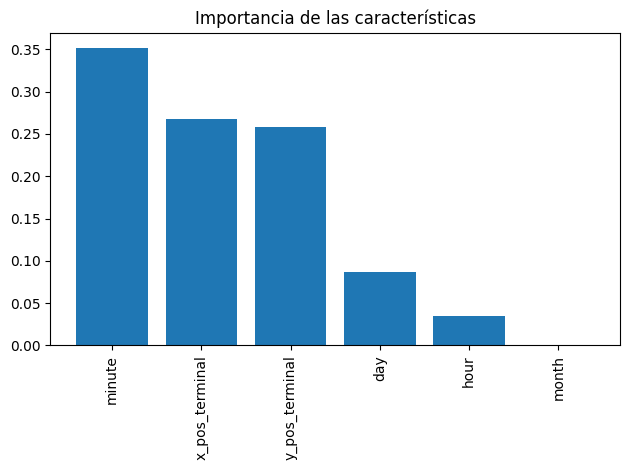

In [16]:
# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar las características por importancia descendente
indices = np.argsort(importances)[::-1]

# Crear una gráfica de barras de la importancia de las características
plt.figure()
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

### Curvas de aprendizaje

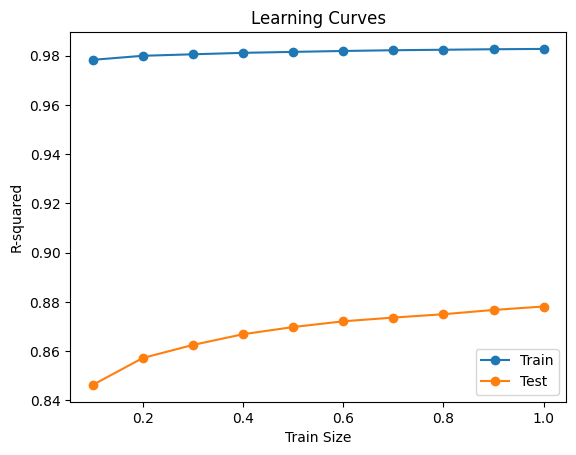

In [5]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []
test_scores = []

for train_size in train_sizes:
    # Tamaño del conjunto de entrenamiento actual
    current_train_size = int(train_size * len(X_train))
    
    # Subconjunto de entrenamiento actual
    X_train_subset = X_train[:current_train_size]
    y_train_subset = y_train[:current_train_size]
    
    # Entrenar el modelo
    model = RandomForestRegressor(oob_score=True)
    model.fit(X_train_subset, y_train_subset)
    
    # Predecir en el conjunto de entrenamiento y prueba
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test)
    
    # Calcular el rendimiento (por ejemplo, R-squared)
    train_score = r2_score(y_train_subset, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Agregar a las listas de puntajes
    train_scores.append(train_score)
    test_scores.append(test_score)

# Graficar las curvas de aprendizaje
plt.plot(train_sizes, train_scores, 'o-', label='Train')
plt.plot(train_sizes, test_scores, 'o-', label='Test')
plt.xlabel('Train Size')
plt.ylabel('R-squared')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [6]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)
rounded_df = pd.DataFrame(y_pred_rounded, columns=y_test.columns)
rounded_df.to_csv('../output/predicciones.csv', index=False)

[[16.22537171  8.48047834  2.         28.          4.         10.        ]
 [41.75221016  9.94781183  3.          3.          9.         42.        ]
 [31.83766741 22.15617496  4.         13.          3.         39.        ]
 ...
 [10.77373366 24.131319    3.         21.          6.         49.        ]
 [ 7.84727388 12.62419729  3.         12.         15.         10.        ]
 [ 1.76632171 25.34565413  3.         11.         20.         19.        ]]


### Validación

In [7]:
import seaborn as sns

In [8]:
validacion_directorio = '../validation/'

dataframe_validation = []

for archivo in os.listdir(validacion_directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(validacion_directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data_val = pickle.load(f)
        dataframe_validation.append(data_val)

# Combina los DataFrames en uno solo
data_val = pd.concat(dataframe_validation, ignore_index=True)

In [9]:
data_val = data_val.drop('TRANSACTION_ID', axis=1)
data_val = data_val.drop('CLIENTE_ID', axis=1)
data_val = data_val[data_val['TX_FRAUD'] == 1]
data_val = data_val.sort_values(by=['TX_DATETIME'])
print(data_val.head())
print("total-filas: ",len(data_val) )

  TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX         TX_DATETIME  \
1                     1524      0         466  139447.11 2023-02-25 00:25:24   
3                     1805      0         406   92739.05 2023-02-25 00:30:05   
4                     1911      0         363  115776.96 2023-02-25 00:31:51   
7                     3108      0          99  124855.45 2023-02-25 00:51:48   
8                     3445      0          65   82575.39 2023-02-25 00:57:25   

     year  month   day  hour  minute  x_pos_terminal  y_pos_terminal  \
1  2023.0    2.0  25.0   0.0    25.0        1.287674       14.557697   
3  2023.0    2.0  25.0   0.0    30.0       46.924095       17.151405   
4  2023.0    2.0  25.0   0.0    31.0       42.144992        3.390347   
7  2023.0    2.0  25.0   0.0    51.0       30.838918       47.450816   
8  2023.0    2.0  25.0   0.0    57.0       29.287964       48.479787   

   TX_FRAUD  TX_FRAUD_SCENARIO  
1         1                  1  
3         1         

In [10]:
X_val = data_val[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y_val = data_val[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# Realizar predicciones en el conjunto de prueba
y_pred_val = model.predict(X_val)

y_pred_val_original = y_pred_val.copy()  # Copia los valores predichos

y_pred_rounded_val = y_pred_val.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded_val[:, -4:] = y_pred_rounded_val[:, -4:].round().astype(int)

print(y_pred_rounded_val)
rounded_df_val = pd.DataFrame(y_pred_rounded_val, columns=y_val.columns)
rounded_df_val.to_csv('../output/predicciones_val.csv', index=False)

# Calcular las métricas
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir las métricas
print("VAL - Mean Squared Error (MSE):", mse_val)
print("VAL - Mean Absolute Error (MAE):", mae_val)
print("VAL - R-squared:", r2_val)


[[ 3.6880945  12.2998008   2.         27.          5.         25.        ]
 [46.90029761 17.26002884  1.         25.          2.         31.        ]
 [42.06420239  2.42180412  2.         25.          1.         32.        ]
 ...
 [46.37271821 10.77892228  3.         14.         22.         43.        ]
 [16.13742461 28.08666204  3.         14.         21.         48.        ]
 [35.92057984  6.37346439  3.         14.         22.         55.        ]]
VAL - Mean Squared Error (MSE): 0.6464096248488695
VAL - Mean Absolute Error (MAE): 0.5908775837025501
VAL - R-squared: 0.7827431773396877


In [11]:
print(y_pred_val_original)

[[ 3.6880945  12.2998008   1.84       26.8         5.16       25.07      ]
 [46.90029761 17.26002884  1.48       25.06        1.63       30.55      ]
 [42.06420239  2.42180412  1.5        25.49        1.24       32.34      ]
 ...
 [46.37271821 10.77892228  3.31       14.1        22.21       42.85      ]
 [16.13742461 28.08666204  3.07       14.34       20.63       47.89      ]
 [35.92057984  6.37346439  3.26       14.26       21.84       55.27      ]]


#### Gráfico de dispersión

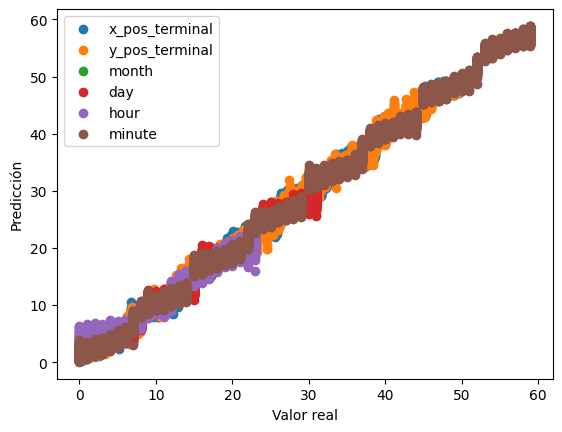

In [12]:
plt.scatter(y_val['x_pos_terminal'], y_pred_val[:, 0], label='x_pos_terminal')
plt.scatter(y_val['y_pos_terminal'], y_pred_val[:, 1], label='y_pos_terminal')
plt.scatter(y_val['month'], y_pred_val[:, 2], label='month')
plt.scatter(y_val['day'], y_pred_val[:, 3], label='day')
plt.scatter(y_val['hour'], y_pred_val[:, 4], label='hour')
plt.scatter(y_val['minute'], y_pred_val[:, 5], label='minute')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.legend()
plt.show()

#### Gráfico de residuos

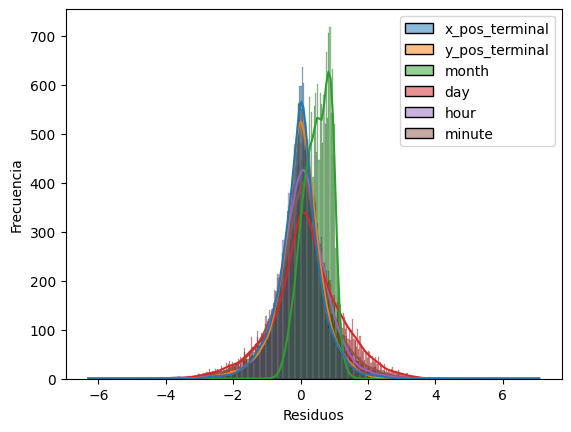

In [13]:
residuals = y_val - y_pred_val
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

#### Gráfico de linea de referencia

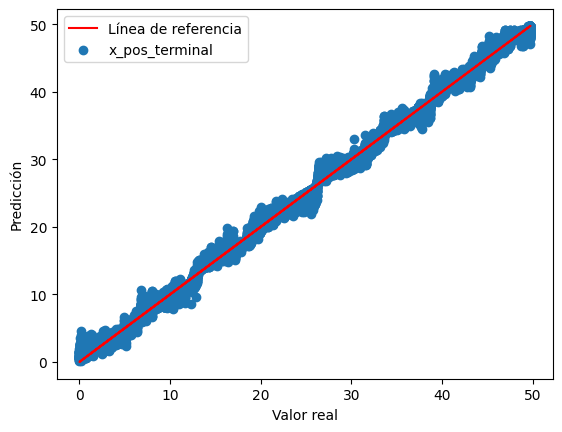

In [14]:
plt.plot(y_val['x_pos_terminal'], y_val['x_pos_terminal'], label='Línea de referencia', color='r')
plt.scatter(y_val['x_pos_terminal'], y_pred_val[:, 0], label='x_pos_terminal')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.legend()
plt.show()

## Exportación del modelo

In [15]:
# Exportar el modelo
with open('../APP-DataScience/modelo.pkl', 'wb') as f:
    pickle.dump(model, f)